In [1]:
import torch
import yaml
import os
import yaml
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import sys
import random
sys.path.append('/mnt/weka/scratch/yang.liu3/pyworkspace/3DGS')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scene.datasets import GSDataset
from scene import LargeScene, GaussianModelLoD
from gaussian_renderer import render, render_v2, render_v3
from arguments import GroupParams
from utils.camera_utils import loadCam

In [2]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

## 1. Render with GS in CPU

In [3]:
config = '../config/lod_mc_aerial_block3_vox_ft_lvl2_1e-2.yaml'

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
# lp.source_path = os.path.join("../", lp.source_path)
lp.source_path = os.path.join("../", "data/matrix_city/aerial/test/block_3_test")
lp.pretrain_path = os.path.join("../", "output/lod_mc_aerial_block3_vox_avg/point_cloud/iteration_15000")
lp.model_path = os.path.join("../output/", config_name)

with torch.no_grad():
    gaussians = GaussianModelLoD(lp.sh_degree, device="cpu", **lp.model_config['kwargs'])
    scene = LargeScene(lp, gaussians)
    gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)
    print(f'Init with {len(gaussians.get_opacity)} points\n')

used1 = round(torch.cuda.memory_allocated() / 1024 / 1024, 2)

Reading camera 19/19
Loaded coarse level GS from file.
[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1
Init with 9893315 points



In [4]:
delta=0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max Memory cost of Alg on cuda:0: 259.72 MB


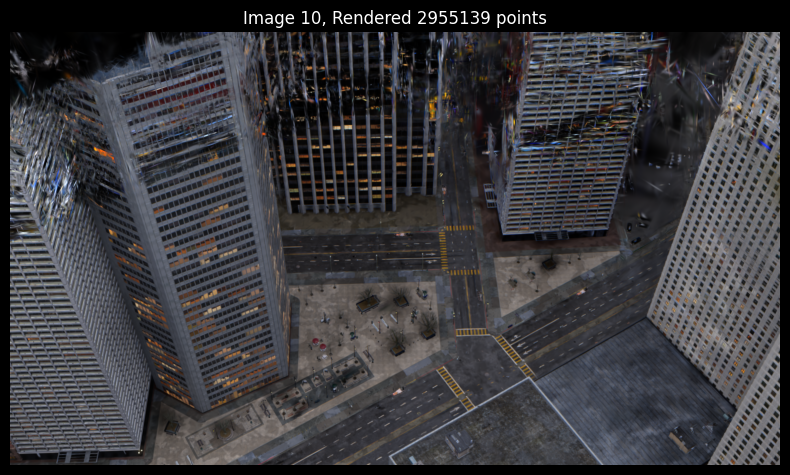

In [10]:
# init, vidia-smi shows 1541M
# lod with 259.72M, nvidia-smi shows 3375M
# org with 417.03M, nvidia-smi shows 5819M
# gaussians.lod_threshold = torch.tensor([100, 100, torch.inf], device=gaussians.device).float()
with torch.no_grad():
    idx = random.randint(0, len(gs_dataset)-1)

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    cam_info, gt_image = gs_dataset[idx]
    render_pkg = render_v3(cam_info, gaussians, pp, background)
    image = render_pkg["render"]
    used2 = round(torch.cuda.memory_allocated() / 1024 / 1024, 2)
    delta = max(delta, used2-used1)
    print(f'Max Memory cost of Alg on {image.device}: {delta} MB')
    image = image.cpu().numpy().transpose(1,2,0)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Image {idx}, Rendered {render_pkg['radii'].shape[0]} points")
    plt.axis(False)
    plt.tight_layout()
    plt.show()

## 2. Render with GS in GPU

In [10]:
config = '../config/lod_mc_aerial_block3_vox_ft_all.yaml'

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
lp.source_path = os.path.join("../", lp.source_path)
lp.pretrain_path = os.path.join("../", "output/lod_mc_aerial_block3_vox_ft_all/point_cloud/iteration_7000")
lp.model_path = os.path.join("../output/", config_name)

with torch.no_grad():
    gaussians = GaussianModelLoD(lp.sh_degree, **lp.model_config['kwargs'])
    scene = LargeScene(lp, gaussians)
    gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)
    print(f'Init with {len(gaussians.get_opacity)} points\n')

Reading camera 185/185
Loaded coarse level GS from file.
Init with 8144526 points



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


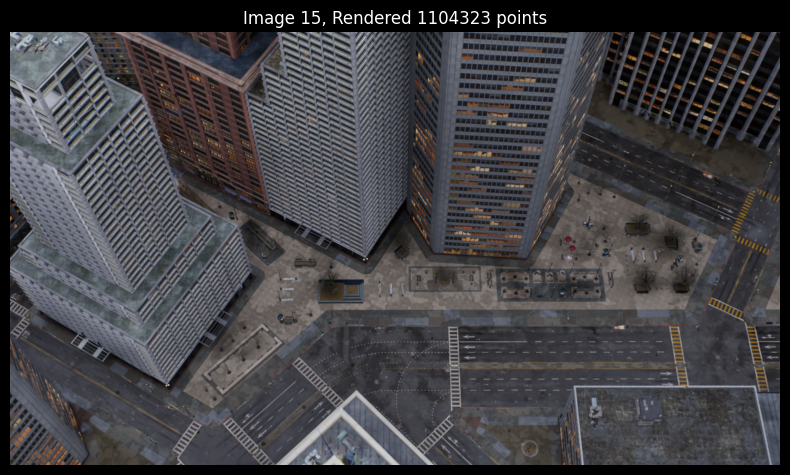

In [55]:
gaussians.lod_threshold = torch.tensor([0, 100]+[torch.inf]).float().cuda()
with torch.no_grad():
    idx = random.randint(0, len(gs_dataset)-1)

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    cam_info, gt_image = gs_dataset[idx]
    render_pkg = render_v2(cam_info, gaussians, pp, background)
    image = render_pkg["render"]
    image = image.cpu().numpy().transpose(1,2,0)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Image {idx}, Rendered {render_pkg['radii'].shape[0]} points")
    plt.axis(False)
    plt.tight_layout()
    plt.show()